In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize 

In [2]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ']

In [3]:
end_date = datetime.today()
start_date = end_date - timedelta(days = 5*365)
print(start_date)

2019-12-02 13:42:06.535721


In [4]:
adj_close_df = pd.DataFrame()

In [5]:
for ticker in tickers:
    data = yf.download(ticker, start= start_date, end =end_date)
    adj_close_df[ticker] = data['Adj Close']    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
print(adj_close_df)

                   SPY        BND         GLD         QQQ
Date                                                     
2019-12-02  288.483154  73.413216  137.789993  196.765991
2019-12-03  286.548462  73.807045  139.110001  195.224808
2019-12-04  288.316528  73.658272  138.919998  196.213486
2019-12-05  288.834930  73.579521  139.000000  196.601212
2019-12-06  291.473175  73.483269  137.619995  198.704575
...                ...        ...         ...         ...
2024-11-22  595.510010  72.589996  249.839996  505.790009
2024-11-25  597.530029  73.260002  242.479996  506.589996
2024-11-26  600.650024  73.129997  242.949997  509.309998
2024-11-27  598.830017  73.330002  243.490005  505.299988
2024-11-29  602.549988  73.599998  245.589996  509.739990

[1258 rows x 4 columns]


In [7]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

In [8]:
log_returns = log_returns.dropna()

In [9]:
cov_matrix = log_returns.cov()*252
print(cov_matrix)

          SPY       BND       GLD       QQQ
SPY  0.044200  0.003081  0.004968  0.050169
BND  0.003081  0.004923  0.003779  0.003705
GLD  0.004968  0.003779  0.023944  0.006609
QQQ  0.050169  0.003705  0.006609  0.065704


In [10]:
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return (weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return(expected_return (weights, log_returns) - risk_free_rate) / standard_deviation (weights, cov_matrix)

In [11]:
from fredapi import Fred

fred = Fred(api_key ='4c81144b3151d46892536b115ea9dc53')
ten_year_treasury_rate = fred.get_series_latest_release('GS10')/ 100

risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

0.040999999999999995


In [12]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

In [13]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) -1}
bounds = [(0,0.5) for _ in range(len(tickers))]

In [14]:
initial_weights = np.array([1/len(tickers)]*len(tickers))

In [15]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args = (log_returns, cov_matrix, risk_free_rate), method ='SLSQP', constraints = constraints, bounds=bounds)

In [16]:
optimal_weights = optimized_results.x

In [17]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

print()

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.0000
BND: 0.0000
GLD: 0.5000
QQQ: 0.5000

Expected Annual Return: 0.1533
Expected Volatility: 0.1604
Sharpe Ratio: 0.7006


<function matplotlib.pyplot.show(close=None, block=None)>

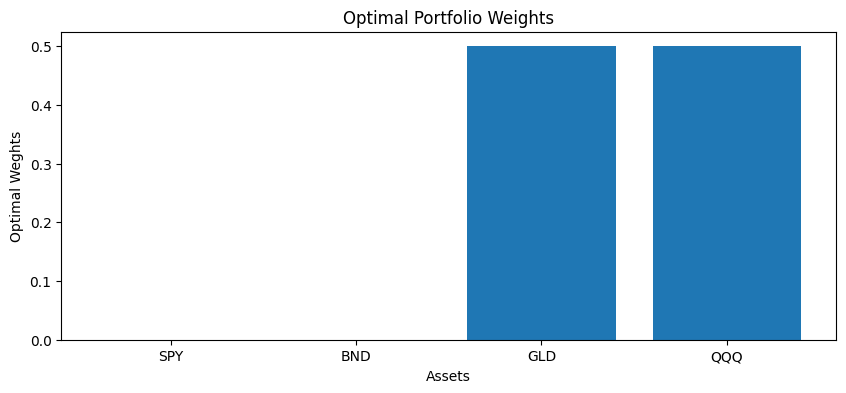

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weghts')
plt.title('Optimal Portfolio Weights')

plt.show